In [1]:
import numpy as np
import scipy

from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation
#from scipy.linalg import expm

import time
import pickle
from pasqal_cloud import SDK
from pasqal_cloud.device import EmulatorType

import pulser
import qutip
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import RampWaveform, ConstantWaveform
from pulser.devices import Chadoq2, MockDevice

/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


## Cloud setup

In [2]:

project_id = "1d856b2d-58b1-4602-ad8a-e18f2db96bc3"
username = "br.ventura@reply.com"
password = "lol"


CLOUD = False

## Graph MOF extraction

In [3]:
def MOF_reader(mol_str):
   with open('dataset_txt/'+mol_str+'_txt') as file:
    lines = file.readlines()
    N = len(lines)-1
    d = float(lines[0])
    plane_coords = np.array([lines[i].split() for i in range(1,N+1)], float)
    
    return d, plane_coords

In [4]:
MOF = "FIVNAZ"


In [5]:

d,coords = MOF_reader(MOF)
coords

array([[ 0.94776995,  0.73063251],
       [ 0.23660176,  0.49906945],
       [ 1.65928782,  0.49995128],
       [ 0.94840897, -0.01728035],
       [ 2.05433999, -0.11556266],
       [ 0.50781761,  1.33538215],
       [ 1.38694056,  1.33592941],
       [-0.49292928,  0.44921417],
       [ 2.62285704, -0.57556906],
       [ 1.4593332 , -0.54069449],
       [ 2.49957401, -1.29625805],
       [ 1.77470139, -1.20053011]])

In [6]:
Omega = 1   * 2*np.pi
delta = 0.7 * 2*np.pi
U = 138e5

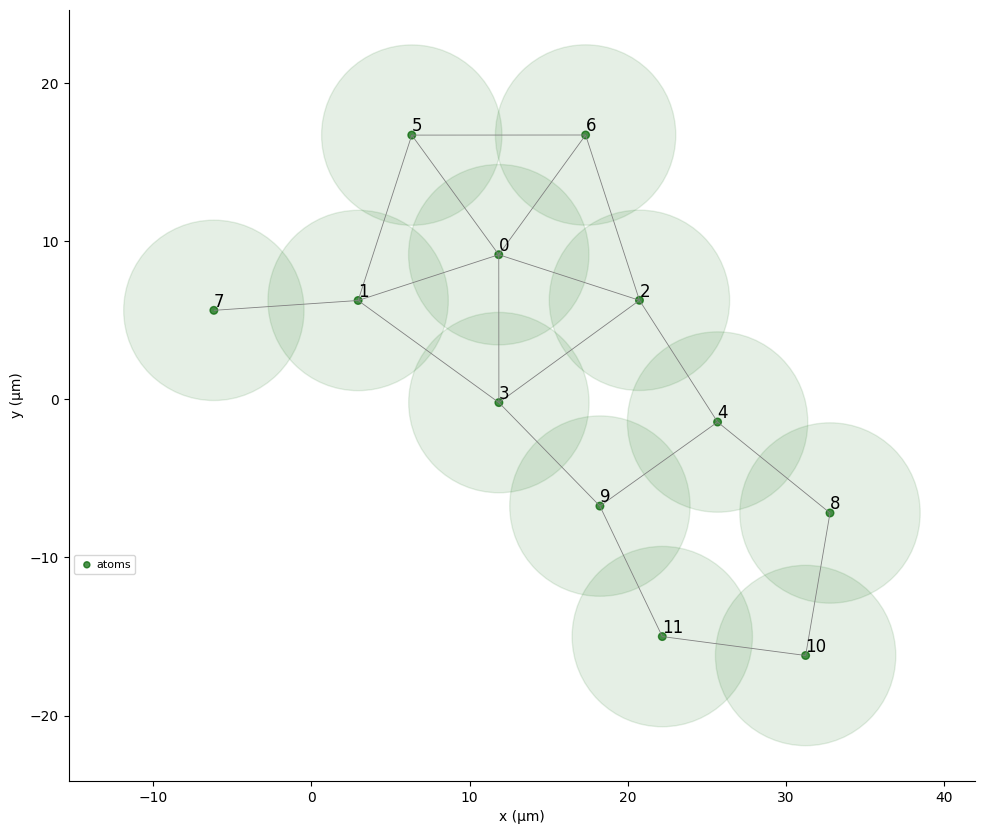

In [7]:

n = len(coords)
#n = 6

def graph_desc(rNN):
   
    G1 = [rNN*np.array([c[0],c[1]]) for c in coords/d/3]
    #G1 = [[rNN*i, 0] for i in range(6)]
    return G1

G1 = graph_desc(15)


        
def excitation(j, total_sites):
    """The |0><0| projector operator on site j."""
    prod = [qutip.qeye(2) for _ in range(total_sites)]
    prod[j] = (qutip.qeye(2) + qutip.sigmaz()) / 2
    return qutip.tensor(prod)


def excitation2(l, n = 6):
    """The |0><0| projector operator on site j."""
    prod = [qutip.qeye(2) for _ in range(n)]
    for j in l:
        prod[j] = (qutip.qeye(2) + qutip.sigmaz()) / 2
    return qutip.tensor(prod)



excited = excitation2([0,1,2,3,4,5],n)

excited = excitation(5,n)


qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True)

In [8]:
seq = Sequence(reg1, MockDevice)
seq.declare_channel("ising", "rydberg_global")


M = 10000
sampling_rate = 1/100


In [9]:
#print('Enter your name:')


In [10]:
K = 100
rNN_vec = np.linspace(25,3.,K)


In [11]:
if(CLOUD):
    print("You are about to launch jobs on the cloud, continue ?")
    x = input()
    if(x=="y"):
        print('Good')
    else:
        raise SystemExit(0)


In [12]:
#papermill_description=TQDM_DESCRIPTION

datafolder_Time_state_Evolution = "./dataset_txt/Time_evolution/"
datafolder_FFT_obs_Evolution = "./dataset_txt/FFT_feature/"



L = int(sampling_rate*M)
T = np.linspace(0,int(M/1000),L)
#STATE = np.zeros((K,L,2**n), dtype=complex)
STATE = []


results = []
for k in range(K):
    if(k%10==0):
        print(k)
    r = rNN_vec[k]
    G1 = graph_desc(r)
    
    qubits1 = dict(enumerate(G1))
    reg1 = Register(qubits1)

    seq = Sequence(reg1, MockDevice)
    seq.declare_channel("rydberg", "rydberg_global")
    

    
    simple_pulse = Pulse.ConstantPulse(M, Omega, 3*Omega, 0)
    
    #_omega = ConstantWaveform(M, Omega/10)
    #_omega = RampWaveform(M, rNN_vec[0]**6/1000, rNN_vec[24]**6/1000)
    #_delta = RampWaveform(M, 4, 20)  # Duration: 1000ns, linear sweep from -20 to 20 rad/µs
    #_delta = ConstantWaveform(M, 0.7*2*np.pi)
    
    #simple_pulse = Pulse(_omega,_delta,phase=0)

    seq.add(simple_pulse, "rydberg")
    seq.measure(basis="ground-rydberg")
    
    serialized_sequence = seq.to_abstract_repr()

    
    if(not CLOUD):
        sim = QutipEmulator.from_sequence(seq,sampling_rate=sampling_rate)
        result = sim.run(progress_bar=False, nsteps=500000)
        # Store state vector
        #for i in range(L):
        #    STATE[k,i,:] = np.array(result.get_state(T[i])).reshape(2**n)
        #
        STATE.append(result)
        results.append(result.expect([excited])[0])
        
        qutip.qsave(STATE, datafolder_Time_state_Evolution+MOF)
        qutip.qsave(results, datafolder_FFT_obs_Evolution+MOF)
    else:
        # Initialize the cloud client
        sdk = SDK(username=username, password=password, project_id=project_id)
        # When creating a job, select a number of runs and set the desired values for the variables
        # defined in the sequence
        job1 = {"runs": 1000}

        # You can also choose to run your batch on an emulator using the optional argument 'emulator'
        # For using a basic single-threaded QPU emulator that can go up to 10 qubits, you can specify the "EMU_FREE" emulator.
        batch = sdk.create_batch(
            serialized_sequence, [job1], emulator=EmulatorType.EMU_TN, wait=True
             )

            # print(f"job-id: {job.id}, status: {job.status}, result: {job.result}")
        #for job in batch.ordered_jobs:
            #print(f"job-id: {job.id}, status: {job.status}, result: {job.result}")
        #job.result

qutip.qsave(STATE, datafolder_Time_state_Evolution+MOF)

qutip.qsave(results, datafolder_FFT_obs_Evolution+MOF)
    #results.append(result.expect([excited])[0])


0


/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/pulser/register/register.py:375: UserWarning: Register serialization to an abstract representation irreversibly converts all qubit ID's to strings.
  names = stringify_qubit_ids(self._ids)


10
20
30
40
50
60
70
80
90


/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [ ]:
#STATE = qutip.qload(datafolder_Time_state_Evolution+MOF)


Quantum object: dims = [[2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1]], shape = (64, 1), type = ket
Qobj data =
[[0.00090285-0.00036003j]
 [0.00278289-0.00090659j]
 [0.00284881-0.00075579j]
 [0.00857855-0.00211739j]
 [0.00285725-0.00075687j]
 [0.00874253-0.00167727j]
 [0.00874771-0.00164226j]
 [0.02632132-0.00445528j]
 [0.00285725-0.00075687j]
 [0.00876748-0.00167853j]
 [0.00888588-0.00119712j]
 [0.02671725-0.00309253j]
 [0.00877343-0.00164234j]
 [0.02672192-0.00306823j]
 [0.0267249 -0.0029827j ]
 [0.08031802-0.00747657j]
 [0.00284881-0.00075579j]
 [0.0087423 -0.00167785j]
 [0.00888516-0.00119825j]
 [0.0267167 -0.0030944j ]
 [0.00888588-0.00119712j]
 [0.02696878-0.00170525j]
 [0.02696928-0.00159922j]
 [0.08097697-0.00330887j]
 [0.00874771-0.00164226j]
 [0.02672137-0.00307009j]
 [0.02696928-0.00159922j]
 [0.08098204-0.00324381j]
 [0.0267249 -0.0029827j ]
 [0.08098182-0.00323503j]
 [0.08097073-0.00298207j]
 [0.24300762-0.00447151j]
 [0.00278289-0.00090659j]
 [0.00857379-0.0021446j ]
 [0.0087423

In [ ]:
#

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

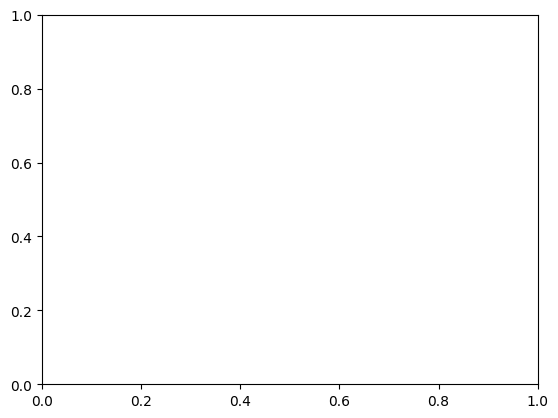

In [ ]:
results = np.array(results)

#T = np.linspace(0,4,int(M*sampling_rate))

fig, ax = plt.subplots()
l, = plt.plot(T,results[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
#ax.set_ylim([0,2])

def animate(i):
    l.set_data(T,results[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=25, frames=K)

       
HTML(ani.to_jshtml())

In [ ]:
#print(dt)
#print((scipy.fft.fftfreq(M*10, dt/10)))
#print(results)
#print(1/dt)
#print(scipy.fft.fftfreq(M, dt))
int(M*sampling_rate)

100

In [ ]:
# For better frequency resolution



FFT = np.zeros((K,int(M*sampling_rate//2)))
FFTw = np.zeros((K,int(M*sampling_rate//2)))
dt = T[1]-T[0]
xf = scipy.fft.fftfreq(int(M*sampling_rate), dt)[:int(M*sampling_rate//2)]

from scipy.signal.windows import blackman
#window = blackman(T.shape[-1]//samplinsg_rate+1)

for i in range(K):
    results_sampled = results[i,:]

    FFT[i,:] = 2/M/sampling_rate*np.abs(scipy.fft.fft(results_sampled)[:int(M*sampling_rate//2)])
    #FFTw[i,:] = 2/M*np.abs(scipy.fft.fft(results_sampled*window)[:M//sampling_rate//2])
    


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(len(xf))
print(xf)


50
[0.     0.0099 0.0198 0.0297 0.0396 0.0495 0.0594 0.0693 0.0792 0.0891
 0.099  0.1089 0.1188 0.1287 0.1386 0.1485 0.1584 0.1683 0.1782 0.1881
 0.198  0.2079 0.2178 0.2277 0.2376 0.2475 0.2574 0.2673 0.2772 0.2871
 0.297  0.3069 0.3168 0.3267 0.3366 0.3465 0.3564 0.3663 0.3762 0.3861
 0.396  0.4059 0.4158 0.4257 0.4356 0.4455 0.4554 0.4653 0.4752 0.4851]


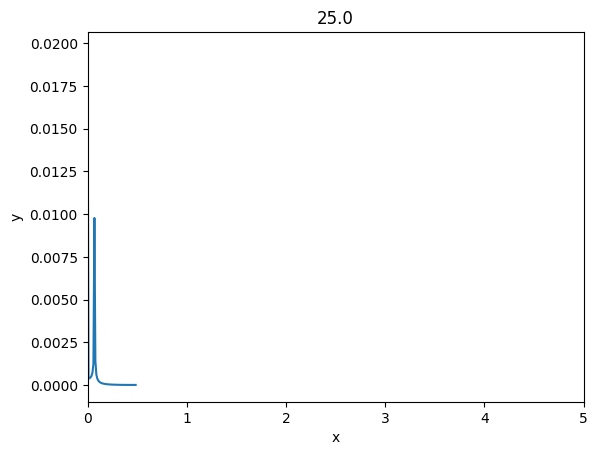

In [ ]:
fig, ax = plt.subplots()
l, = plt.plot(xf,FFT[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
#ax.set_ylim([0,0.75])
ax.set_xlim([0,5])

def animate(i):
    l.set_data(xf,FFT[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=100, frames=K)

       
HTML(ani.to_jshtml())

# ani.save('FFT_rNN_hexa.gif')

In [ ]:
np.log(FFT[0,:])

array([ -3.92859193,  -7.89022662,  -7.82913738,  -7.71792815,
        -7.53732581,  -7.24212393,  -6.69403337,  -4.62773819,
        -6.56673796,  -7.40496666,  -7.9001968 ,  -8.26249845,
        -8.55298941,  -8.79816012,  -9.02419522,  -9.20230974,
        -9.37530274,  -9.53415101,  -9.68153268,  -9.81940081,
        -9.94923737, -10.0721914 , -10.18916303, -10.30086747,
       -10.40786511, -10.51059349, -10.60938288, -10.70446821,
       -10.79599768, -10.88403597, -10.96857265, -11.04952245,
       -11.12673572, -11.20000719, -11.26909093, -11.33371946,
       -11.39363082, -11.44859159, -11.49842848, -11.54305052,
       -11.5824649 , -11.61678194, -11.64620665, -11.67102355,
       -11.69156379, -11.70818407, -11.72123165, -11.73102145,
       -11.73781624, -11.74181224])

In [ ]:
print(Omega/2/np.pi*np.sqrt(n))

2.449489742783178


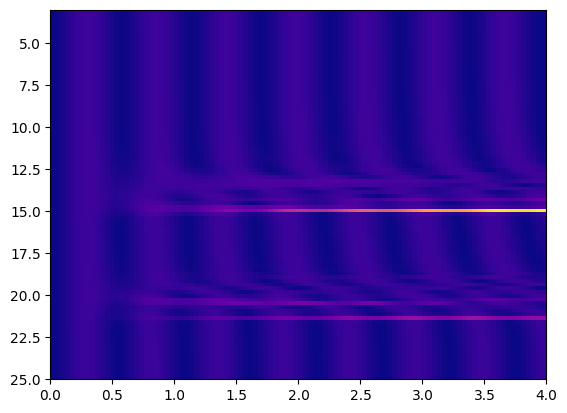

In [ ]:

plt.imshow(results, cmap='plasma', interpolation='nearest',extent=(0,4,25,3), aspect='auto')
plt.show()

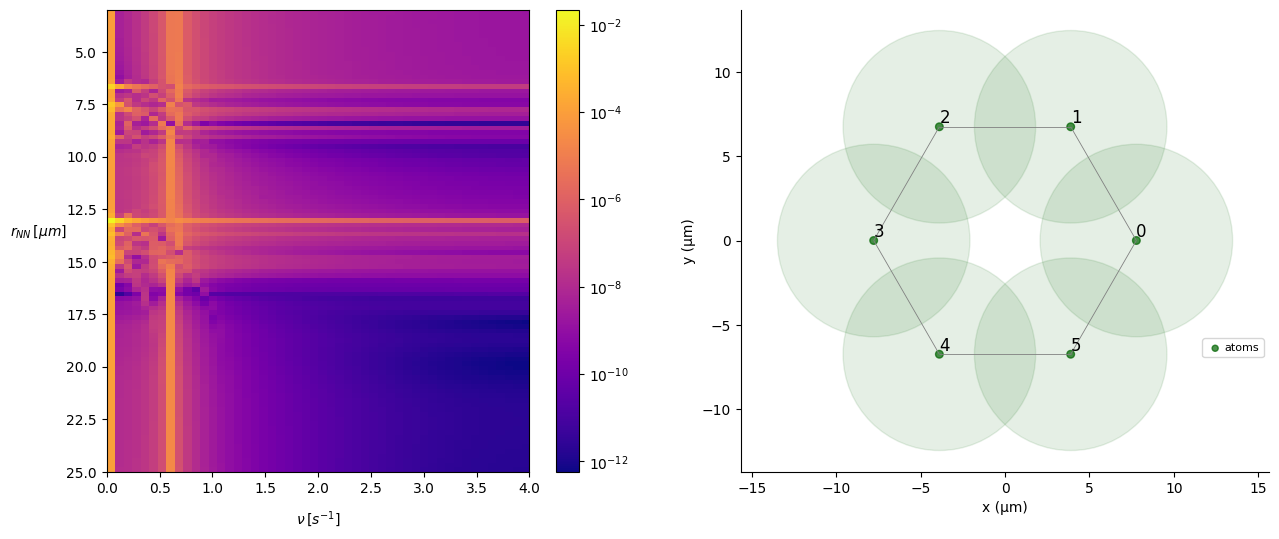

In [ ]:
#fftbis = np.array([FFT[i,:],rNN_vec[i] for i in range(100)])
#print(fftbis.shape)
#fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
plt.rcParams['text.usetex'] = False
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.set_ylabel(r'$r_{NN}\, [\mu m]$',rotation=0,labelpad=20)#, loc='top')
ax1.set_xlabel(r'$\nu\,[s^{-1}]$',rotation=0,labelpad=10)#, loc='right')
im = ax1.imshow(np.log(FFT[:,:]),cmap='plasma',origin='lower', interpolation='nearest', extent=(0,4,25,3), aspect='auto')
#ax2.imshow(np.log(FFTw),cmap='plasma',origin='lower', interpolation='nearest', extent=(0,4,25,0.5))
#ax1.setgrid()
ax1.set_title("")

import matplotlib.ticker as ticker
def fmt(x, pos):
    #a, b = '{:.2e}'.format(x).split('e')
    #b = int(b)
    return r'$10^{{{}}}$'.format(int(x))

plt.colorbar(im, format=ticker.FuncFormatter(fmt))
#fig.colorbar(im)
#ax1.grid(alpha=0.5, linestyle='-', linewidth=1)
G1 = graph_desc(11)

qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True,custom_ax=ax2)


plt.show()